- dataset을 임의로 선정해서 직접 분석 해보기(제공한 코드를 활용해서 해보기)
- activation functions 중 relu사용시 함수 직접 정의
- lr, optimizer 등 바꿔보기
- hidden layer/neuron 수를 바꾸기
- 전처리도 추가
- 모든 시도를 올려주세요!
- 제일 높은 acc를 보인 시도를 명시해주세요!


In [1]:
import pandas as pd
import torch
from torch import nn, optim
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_wine
from torch.utils.data import  TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
data=load_wine()

전처리

In [3]:
df = pd.concat([pd.DataFrame(data.data, columns=data.feature_names), pd.DataFrame(data.target, columns=['target'])], axis=1)

In [4]:
df.isnull().sum()   # 결측치 없음

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
target                          0
dtype: int64

In [5]:
df.describe()   # 전부 numeric > 표준화 필요해보임

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


In [6]:
input = data.data
output = data.target

In [7]:
input1 = pd.DataFrame(input, columns = data.feature_names)

In [8]:
from sklearn.preprocessing import StandardScaler

# Standardization 평균 0 / 분산 1
scaler = StandardScaler()   
scaler = scaler.fit_transform(input1)

In [9]:
input = input1.to_numpy()

데이터 분석

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.3, random_state = 42, stratify= data.target, shuffle = True)

x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

# 데이터를 tensor로 바꿔주고 gpu 연산이 가능해지도록 gpu에 옮김
# label 값을 왜 long 에 옮겨놓는가? loss function이 다르기 때문 

In [12]:
print(len(data.feature_names))
print(data.target_names)

13
['class_0' 'class_1' 'class_2']


In [13]:
print(x_train[0])
print(y_train[0])

#input 13개 (속성이 13개)
#y의 class는 3개 (class0, 1, 2)

tensor([1.3750e+01, 1.7300e+00, 2.4100e+00, 1.6000e+01, 8.9000e+01, 2.6000e+00,
        2.7600e+00, 2.9000e-01, 1.8100e+00, 5.6000e+00, 1.1500e+00, 2.9000e+00,
        1.3200e+03], device='cuda:0')
tensor(0, device='cuda:0')


파이토치에서는 데이터셋을 좀 더 쉽게 다룰 수 있도록 유용한 도구로서 torch.utils.data.Dataset과 torch.utils.data.DataLoader를 제공합니다. 이를 사용하면 미니 배치 학습, 데이터 셔플(shuffle), 병렬 처리까지 간단히 수행할 수 있습니다. 기본적인 사용 방법은 Dataset을 정의하고, 이를 DataLoader에 전달하는 것
- init : class 에서 객체가 생성되면 바로 실행되는 함수
- len : observation 수를 정의하는 함수
- getitem : iteration 마다 해당하는 데이터를 돌려주는 함수

In [14]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self):
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

In [15]:
batch_size = 8

dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size=batch_size) 

In [16]:
model = nn.Sequential(
          nn.Linear(13,398, bias=True),
          nn.Sigmoid(),
          nn.Linear(398,15, bias=True),
          nn.Sigmoid(),
          nn.Linear(15,5, bias=True), 
          nn.Softmax()
          ).to(device)

class로 구현 가능
- init : 초기 생성 함수
- foward : 순전파(입력값 => 예측값 의 과정)

In [17]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(13,398, bias=True), # input_layer = 30, hidden_layer1 = 398 
          nn.Sigmoid(),
        nn.BatchNorm1d(398)
    )
  # activation function 이용 
  #   nn.ReLU()
  #   nn.tanH()
  #   https://pytorch.org/docs/stable/nn.html 그 외에도 여기서 확인 가능함 
  #   파라미터가 필요하지 않다는 것이 특징

  # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌
  # 추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용하게 됨 
  # 그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨 

    self.layer2 = nn.Sequential(
          nn.Linear(398,15, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.Sigmoid()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15,10, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.Sigmoid()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 5, bias=True), # hidden_layer3 = 10, output_layer = 5
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [18]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

        #xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서

# Model 1
- 기본 설정대로 진행

In [19]:
model = Model().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=398, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): Softmax(dim=None)
  )
)

In [20]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=398, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): Softmax(dim=None)
  )
)


In [21]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.Adam(model.parameters(), lr= 0.01)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [22]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 1.5411123037338257
10 1.400137186050415
20 1.2934082746505737
30 1.2250208854675293
40 1.1763157844543457
50 1.1400551795959473
60 1.0523244142532349
70 0.9969934821128845
80 0.9682345390319824
90 0.9833006262779236


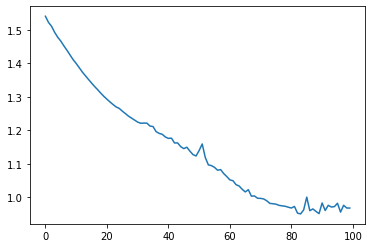

In [23]:
plt.plot(losses)
plt.show()

In [24]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [25]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [9.8827165e-01 5.7466161e-03 4.8704147e-03 6.5667066e-04 4.5466126e-04]
argmax를 한 후의 output은 0
accuracy는 0.9629629629629629


# Model 2 
acc 제일 높았음  


- relu 사용해서 재시도
- epoch 10배
- hidden layer 수 변경
- lr 변경
- 뉴런 변경  

을 시도했지만 대부분 원래 세팅된 값으로 돌렸을 때 acc가 높았음

In [26]:
class Model2(torch.nn.Module):

  def __init__(self):
    super(Model2, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(13,398, bias=True), # input_layer = 30, hidden_layer1 = 398 
          nn.ReLU(),
        nn.BatchNorm1d(398)
    )
  # activation function 이용 
  #   nn.ReLU()
  #   nn.tanH()
  #   https://pytorch.org/docs/stable/nn.html 그 외에도 여기서 확인 가능함 
  #   파라미터가 필요하지 않다는 것이 특징

  # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌
  # 추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용하게 됨 
  # 그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨 

    self.layer2 = nn.Sequential(
          nn.Linear(398,15, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.ReLU()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15,10, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.ReLU()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 5, bias=True), # hidden_layer3 = 10, output_layer = 5
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [27]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

        #xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서

In [28]:
model2 = Model2().to(device)
model2.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model2(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=398, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): Softmax(dim=None)
  )
)

In [29]:
print(model2)

Model2(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=398, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): Softmax(dim=None)
  )
)


In [30]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.Adam(model2.parameters(), lr= 0.01)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [31]:
losses = []
for epoch in range(1000):

  optimizer.zero_grad()
  hypothesis = model2(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 1.6192281246185303
10 1.1452958583831787
20 0.9822261929512024
30 0.9523438811302185
40 0.9446027874946594
50 0.9384719133377075
60 0.9374048113822937
70 0.9367218017578125
80 0.9366391897201538
90 0.9366186857223511
100 0.9366047382354736
110 0.9365972280502319
120 0.9365918636322021
130 0.936587393283844
140 0.936583399772644
150 0.9365813136100769
160 0.9365826845169067
170 0.9365760087966919
180 0.936569094657898
190 0.9364068508148193
200 0.9406071901321411
210 0.9344013929367065
220 0.9186819195747375
230 0.9115817546844482
240 0.9073490500450134
250 0.9054253697395325
260 0.904985249042511
270 0.9049094319343567
280 0.9048853516578674
290 0.9048698544502258
300 0.9048632979393005
310 0.904858410358429
320 0.9048619270324707
330 0.9048599600791931
340 0.9048572182655334
350 0.9048545360565186
360 0.9048523902893066
370 0.9048507213592529
380 0.9048494100570679
390 0.9048482775688171
400 0.9048472046852112
410 0.9048463702201843
420 0.9048457145690918
430 0.904845118522644
440 0

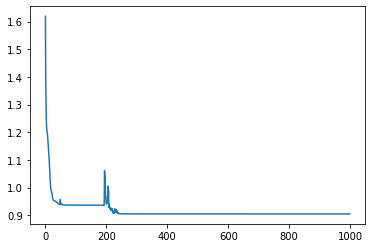

In [32]:
plt.plot(losses)
plt.show()

In [33]:
with torch.no_grad():
  model2 = model2.to('cpu')
  y_pred = model2(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [34]:
print(f'model2의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model2의 output은 :  [1.0000000e+00 1.4847962e-14 2.3642049e-10 2.0963995e-18 1.2646333e-17]
argmax를 한 후의 output은 0
accuracy는 0.9814814814814815


# Model 3
- Model2에서 optimizer를 SGD로 변경

In [35]:
class Model3(torch.nn.Module):

  def __init__(self):
    super(Model3, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(13,398, bias=True), # input_layer = 30, hidden_layer1 = 398 
          nn.ReLU(),
        nn.BatchNorm1d(398)
    )
  # activation function 이용 
  #   nn.ReLU()
  #   nn.tanH()
  #   https://pytorch.org/docs/stable/nn.html 그 외에도 여기서 확인 가능함 
  #   파라미터가 필요하지 않다는 것이 특징

  # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌
  # 추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용하게 됨 
  # 그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨 

    self.layer2 = nn.Sequential(
          nn.Linear(398,15, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.ReLU()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15,10, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.ReLU()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 5, bias=True), # hidden_layer3 = 10, output_layer = 5
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [36]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

        #xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서

In [37]:
model3 = Model3().to(device)
model3.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model3(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=398, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): Softmax(dim=None)
  )
)

In [38]:
print(model3)

Model3(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=398, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): Softmax(dim=None)
  )
)


In [39]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.SGD(model3.parameters(), lr= 0.01, momentum=0.99)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [40]:
losses = []
for epoch in range(1000):

  optimizer.zero_grad()
  hypothesis = model3(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 1.6506229639053345
10 1.5077710151672363
20 1.399988055229187
30 1.275002121925354
40 1.2204511165618896
50 1.2166465520858765
60 1.2158933877944946
70 1.2155003547668457
80 1.215567708015442
90 1.2158291339874268
100 1.215990424156189
110 1.216381549835205
120 1.216270089149475
130 1.2163125276565552
140 1.2163116931915283
150 1.2162621021270752
160 1.216143012046814
170 1.216040849685669
180 1.2158141136169434
190 1.2155303955078125
200 1.2150623798370361
210 1.2146700620651245
220 1.2139683961868286
230 1.213379979133606
240 1.2128294706344604
250 1.2122492790222168
260 1.2115869522094727
270 1.2109845876693726
280 1.2102727890014648
290 1.209640383720398
300 1.2088650465011597
310 1.2080751657485962
320 1.2073458433151245
330 1.2069953680038452
340 1.2068384885787964
350 1.2060511112213135
360 1.2047109603881836
370 1.2039344310760498
380 1.2035276889801025
390 1.200097918510437
400 1.2042386531829834
410 1.2064063549041748
420 1.2101269960403442
430 1.212774634361267
440 1.21473

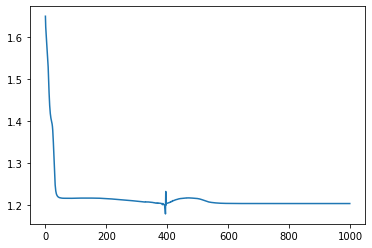

In [41]:
plt.plot(losses)
plt.show()

In [42]:
with torch.no_grad():
  model3 = model3.to('cpu')
  y_pred = model3(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [43]:
print(f'model3의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model3의 output은 :  [1. 0. 0. 0. 0.]
argmax를 한 후의 output은 0
accuracy는 0.7037037037037037
